<td>
    <a target="_blank" href="https://colab.research.google.com/github/jjerry-k/learning_framework/blob/main/03_Advance/GAN/LSGAN/PyTorch.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
</td>

In [1]:
# Importing Modules
import random
from tqdm import tqdm

import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from torch.utils.data import DataLoader 

from torchvision import datasets
from torchvision import transforms

from matplotlib import pyplot as plt

# Device Configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Set randomness
seed = 777
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set hyperparameter
epochs= 10
batch_size= 128
latent_size = 100

In [2]:
# MNIST dataset
transform = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
])

mnist_train = datasets.MNIST(root='../../../data/',
                            train=True,
                            transform=transform,
                            download=True)
print("Downloading Train Data Done ! ")

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=8)

In [6]:
# Defining Model
class Generator(nn.Module):
    def __init__(self, n_z=100, d=128):
        super(Generator, self).__init__() 
        self.deconv1 = nn.ConvTranspose2d(n_z, d*8, 4, 1, 0, bias=False)
        self.bnorm1 = nn.BatchNorm2d(d*8)
        
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1, bias=False)
        self.bnorm2 = nn.BatchNorm2d(d*4)
        
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1, bias=False)
        self.bnorm3 = nn.BatchNorm2d(d*2)
        
        self.deconv4 = nn.ConvTranspose2d(d*2, 1, 4, 2, 1, bias=False)
        
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.normal_(m.weight, 1.0, 0.02)
                nn.init.constant_(m.bias, 0)
                    
    def forward(self, X):
        X = F.relu(self.bnorm1(self.deconv1(X)), True)
        X = F.relu(self.bnorm2(self.deconv2(X)), True)
        X = F.relu(self.bnorm3(self.deconv3(X)), True)
        X = torch.tanh(self.deconv4(X))
        return X
    
class Discriminator(nn.Module):
    def __init__(self, d=128):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, d, 4, 2, 1, bias=False)
        self.bnorm1 = nn.BatchNorm2d(d)
        
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1, bias=False)
        self.bnorm2 = nn.BatchNorm2d(d*2)
        
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1, bias=False)
        self.bnorm3 = nn.BatchNorm2d(d*4)
        
        self.conv4 = nn.Conv2d(d*4, 1, 4, 1, 0, bias=False)
        
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.normal_(m.weight, 1.0, 0.02)
                nn.init.constant_(m.bias, 0)

    def forward(self, X):
        X = F.leaky_relu(self.bnorm1(self.conv1(X)), negative_slope=0.002, inplace=True)
        X = F.leaky_relu(self.bnorm2(self.conv2(X)), negative_slope=0.002, inplace=True)
        X = F.leaky_relu(self.bnorm3(self.conv3(X)), negative_slope=0.002, inplace=True)
        X = torch.sigmoid(self.conv4(X))
        return X

G = Generator(latent_size, 64).to(device)
D = Discriminator(64).to(device)

criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

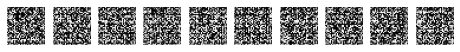

In [7]:
# Helper Function
def plot_generator(G, latent_size=100, num=10):
    z = torch.randn(num, latent_size, 1, 1).to(device)
    
    generated = (G.forward(z).cpu().detach() + 1)*127.5
    plt.figure(figsize=(8, 2))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.imshow(generated[i].view(32, 32).type(torch.uint8), cmap=plt.cm.gray)
        plt.axis('off')
    plt.show()

plot_generator(G)

[1/10]: 100%|██████████| 469/469 [00:26<00:00, 17.64it/s, D loss=0.235, G loss=2.648] 


Epoch : 1, D Loss : 0.148, G Loss : 4.471


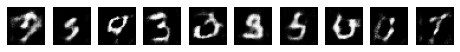

[2/10]: 100%|██████████| 469/469 [00:25<00:00, 18.07it/s, D loss=0.592, G loss=0.766]


Epoch : 2, D Loss : 0.269, G Loss : 2.408


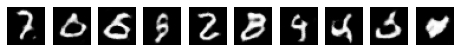

[3/10]: 100%|██████████| 469/469 [00:25<00:00, 18.62it/s, D loss=0.134, G loss=2.993]


Epoch : 3, D Loss : 0.218, G Loss : 2.702


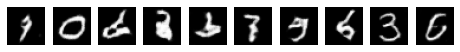

[4/10]: 100%|██████████| 469/469 [00:26<00:00, 17.81it/s, D loss=0.229, G loss=2.925]


Epoch : 4, D Loss : 0.205, G Loss : 2.801


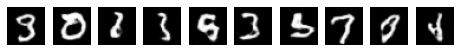

[5/10]: 100%|██████████| 469/469 [00:26<00:00, 17.95it/s, D loss=0.084, G loss=3.339]


Epoch : 5, D Loss : 0.208, G Loss : 2.805


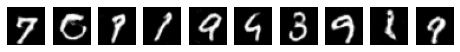

[6/10]: 100%|██████████| 469/469 [00:25<00:00, 18.06it/s, D loss=0.158, G loss=3.729]


Epoch : 6, D Loss : 0.172, G Loss : 3.065


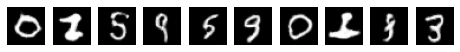

[7/10]: 100%|██████████| 469/469 [00:26<00:00, 17.80it/s, D loss=0.070, G loss=3.878]


Epoch : 7, D Loss : 0.153, G Loss : 3.230


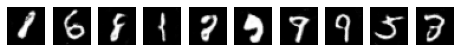

[8/10]: 100%|██████████| 469/469 [00:26<00:00, 17.65it/s, D loss=0.085, G loss=3.523] 


Epoch : 8, D Loss : 0.146, G Loss : 3.454


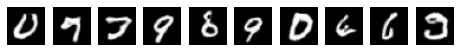

[9/10]: 100%|██████████| 469/469 [00:25<00:00, 18.34it/s, D loss=0.084, G loss=4.281] 


Epoch : 9, D Loss : 0.147, G Loss : 3.461


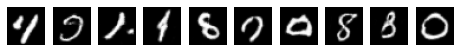

[10/10]: 100%|██████████| 469/469 [00:25<00:00, 18.21it/s, D loss=0.098, G loss=3.196] 


Epoch : 10, D Loss : 0.130, G Loss : 3.639


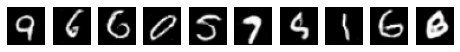

Training Done !


In [8]:
# Training loop
for epoch in range(epochs):
    G.train()
    D.train()
    avg_g_loss = 0
    avg_d_loss = 0
    
    with tqdm(total=len(train_loader)) as t:
        t.set_description(f'[{epoch+1}/{epochs}]')
        for i, (batch_img, _) in enumerate(train_loader):
            
            tmp_batch_siae = batch_img.shape[0]

            X = batch_img.to(device)
        
            real_lab = torch.ones(tmp_batch_siae, 1).to(device)
            
            fake_lab = torch.zeros(tmp_batch_siae, 1).to(device)

            # Training Discriminator
            D_pred = D.forward(X)
            d_loss_real = criterion(D_pred.view(-1, 1), real_lab)
            real_score = D_pred
            
            z = torch.randn(tmp_batch_siae, latent_size, 1, 1).to(device)
            
            fake_images = G.forward(z)
            G_pred = D.forward(fake_images.detach())
            d_loss_fake = criterion(G_pred.view(-1, 1), fake_lab)
            fake_score = G_pred
            
            d_loss = 0.5*(d_loss_real + d_loss_fake)
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()
            
            # Training Generator
            G_pred = D.forward(fake_images)
            g_loss = criterion(G_pred.view(-1, 1), real_lab)
            
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            avg_g_loss += g_loss.item()
            avg_d_loss += d_loss.item()

            
            t.set_postfix({
                            "D loss": f"{d_loss.item():05.3f}", 
                            "G loss": f"{g_loss.item():05.3f}"
                            })
            t.update()

            
    print(f"Epoch : {epoch+1}, D Loss : {avg_d_loss/len(train_loader):.3f}, G Loss : {avg_g_loss/len(train_loader):.3f}")
    plot_generator(G, latent_size)
print("Training Done !")

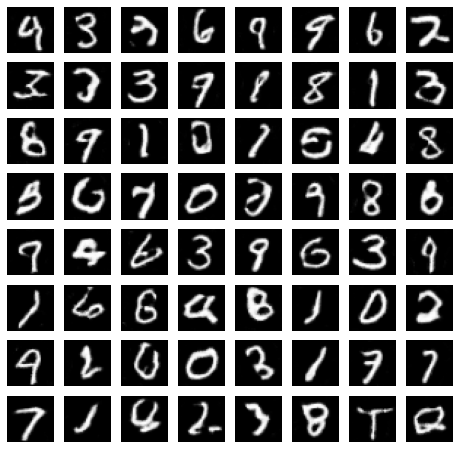

In [9]:
# Sample
num_sample = 64
z = torch.randn(num_sample, latent_size, 1, 1).to(device)

generated = G.forward(z).cpu().detach()
plt.figure(figsize=(8, 8))
for i in range(num_sample):
    plt.subplot(8, 8, i+1)
    plt.imshow(generated[i].view(32, 32), cmap=plt.cm.gray)
    plt.axis('off')
plt.show()